# Last-Mile Delivery Forecasting & Route Optimization

In [1]:
import sys
from pathlib import Path


# Add src/ to Python path
project_root = Path().resolve().parent
sys.path.append(str(project_root / "src"))


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Define Delivery Zones Using NYC Boroughs

### Load NYC Geometry

In [2]:
import osmnx as ox
import geopandas as gpd


nyc = ox.geocode_to_gdf("New York City, USA")
nyc

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((-74.25884 40.49888, -74.25814 ...",-74.258843,40.476578,-73.700233,40.91763,423784731,relation,175905,40.712728,-74.006015,boundary,administrative,10,0.881792,city,New York,"New York, United States"


### Get Road Network

In [3]:
G = ox.graph_from_place("New York City, USA", network_type="drive")

### Create Delivery Zones (Zip-Code Level)

In [4]:
zones = ox.geocode_to_gdf([
    "Manhattan, NY",
    "Brooklyn, NY",
    "Queens, NY",
    "Bronx, NY",
    "Staten Island, NY"
])

zones["zone_id"] = zones.index
zones

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,zone_id
0,"MULTIPOLYGON (((-74.04721 40.69089, -74.0472 4...",-74.047207,40.679654,-73.906769,40.882012,330283055,relation,8398124,40.757955,-73.985532,boundary,administrative,14,0.740755,suburb,Manhattan,"Manhattan, New York County, New York, United S...",0
1,"POLYGON ((-74.05669 40.62704, -74.05541 40.625...",-74.056688,40.550339,-73.832945,40.739434,331959552,relation,9691750,40.652601,-73.949721,boundary,administrative,14,0.738499,suburb,Brooklyn,"Brooklyn, Kings County, New York, United States",1
2,"POLYGON ((-74.04378 40.50783, -73.97787 40.519...",-74.043780,40.492121,-73.700233,40.812135,331531114,relation,9691819,40.713508,-73.828313,boundary,administrative,14,0.669827,suburb,Queens,"Queens, Queens County, New York, United States",2
3,"POLYGON ((-73.93391 40.88201, -73.9253 40.8790...",-73.933907,40.785739,-73.748374,40.917630,333038772,relation,9691916,40.846651,-73.878594,boundary,administrative,14,0.673842,suburb,The Bronx,"The Bronx, Bronx County, New York, United States",3
4,"POLYGON ((-74.25884 40.49888, -74.25814 40.497...",-74.258843,40.476578,-74.034613,40.651506,330461849,relation,9691948,40.583456,-74.149605,boundary,administrative,14,0.629565,suburb,Staten Island,"Staten Island, Richmond County, New York, Unit...",4


### Generate Synthetic Delivery Orders
- 60 days
- Hourly demand
- Zone-level variation
- Rush-hour effects

In [5]:
from data_generation import generate_synthetic_orders


orders_df = generate_synthetic_orders(
    start_date="2024-01-01",
    end_date="2024-03-01",
    zones=len(zones),
    seed=42
)

orders_df.head()

,timestamp,zone_id,order_id,delivery_time_min,on_time
0,2024-01-01,0,O669991378,24.526895,1
1,2024-01-01,0,O359525748,20.355859,1
2,2024-01-01,0,O434285667,26.962899,1
3,2024-01-01,0,O242285876,20.354077,1
4,2024-01-01,1,O787716372,32.311891,1


### Save Raw Data

In [6]:
orders_df.to_csv(
    project_root / "data/raw/synthetic_orders.csv",
    index=False
)

## Predictive Modeling (FORECASTING)

In [7]:
from forecasting import prepare_hourly_demand


hourly_demand = prepare_hourly_demand(orders_df)
hourly_demand.head()

,timestamp,zone_id,orders,hour,dayofweek,is_weekend
0,2024-01-01 00:00:00,0,4,0,0,False
1,2024-01-01 00:00:00,1,3,0,0,False
2,2024-01-01 00:00:00,2,1,0,0,False
3,2024-01-01 00:00:00,3,3,0,0,False
4,2024-01-01 01:00:00,0,3,1,0,False


### Train Demand Forecast Model (Gradient Boosting)

In [8]:
from forecasting import train_demand_model


model, mae = train_demand_model(hourly_demand)

print(f"Demand Forecast MAE: {mae:.2f}")

Demand Forecast MAE: 1.48


### Forecast Future Demand (NEXT 7 DAYS)

In [9]:
from forecasting import forecast_demand


future_df = forecast_demand(
    model=model,
    zones=zones["zone_id"].tolist(),
    periods=7 * 24,
    start_timestamp=hourly_demand["timestamp"].max()
)

future_df.head()

,timestamp,zone_id,hour,dayofweek,is_weekend,forecast_orders
0,2024-03-01,0,0,4,False,3.224511
1,2024-03-01,1,0,4,False,3.217228
2,2024-03-01,2,0,4,False,3.179222
3,2024-03-01,3,0,4,False,3.045213
4,2024-03-01,4,0,4,False,3.197730


### Save Forecast Outputs

In [10]:
hourly_demand.to_csv(
    project_root / "data/processed/hourly_demand.csv",
    index=False
)

future_df.to_csv(
    project_root / "data/processed/demand_forecasts.csv",
    index=False
)

## Prescriptive Optimization

In [11]:
from optimization import optimize_driver_allocation


results_df, total_cost = optimize_driver_allocation(
    forecast_df=future_df,
    cost_per_driver=30,  # $/hour
    late_penalty=50,  # $ per late order
    capacity_per_driver=4,  # orders/hour
    hours_to_optimize=24
)

results_df.head()

,timestamp,zone_id,drivers,late_orders
0,2024-03-01,0,1.0,0.0
1,2024-03-01,1,1.0,0.0
2,2024-03-01,2,1.0,0.0
3,2024-03-01,3,1.0,0.0
4,2024-03-01,4,1.0,0.0


## KPI Computation (BEFORE vs AFTER)

In [12]:
from kpi_calculation import compute_kpis


kpis = compute_kpis(
    results_df=results_df,
    forecast_df=future_df
)

kpis["total_cost"] = total_cost
kpis

{'total_cost': 4500.0,
 'late_orders': np.float64(0.0),
 'driver_hours': np.float64(150.0),
 'on_time_rate': np.float64(1.0)}

###  Save Optimization Outputs

In [13]:
results_df.to_csv(
    project_root / "data/processed/optimization_results.csv",
    index=False
)

pd.DataFrame([kpis]).to_csv(
    project_root / "data/processed/kpis_summary.csv",
    index=False
)

### Demand vs Capacity Plot

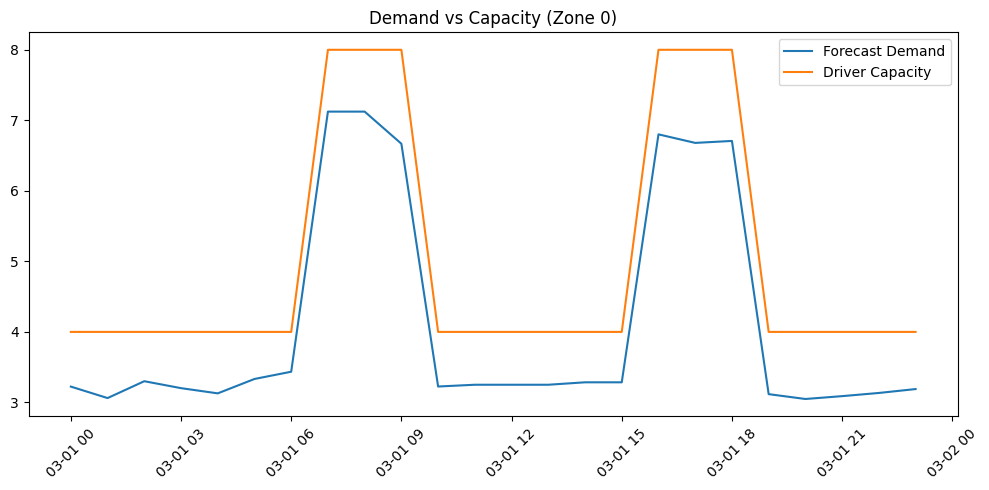

In [14]:
sample_zone = 0

zone_data = future_df[future_df["zone_id"] == sample_zone].head(24)
zone_results = results_df[results_df["zone_id"] == sample_zone]

plt.figure(figsize=(10, 5))
plt.plot(zone_data["timestamp"], zone_data["forecast_orders"], label="Forecast Demand")
plt.plot(
    zone_data["timestamp"],
    zone_results["drivers"] * 4,
    label="Driver Capacity"
)
plt.legend()
plt.title("Demand vs Capacity (Zone 0)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(
    project_root / "outputs/figures/demand_vs_capacity_zone0.png",
    dpi=150
)
plt.show()

### Executive Summary Table

In [15]:
exec_summary = pd.DataFrame({
    "Metric": [
        "Total Cost ($)",
        "Late Orders",
        "Driver Hours",
        "On-Time Delivery Rate"
    ],
    "Value": [
        kpis["total_cost"],
        kpis["late_orders"],
        kpis["driver_hours"],
        round(kpis["on_time_rate"], 3)
    ]
})

exec_summary.to_csv(
    project_root / "outputs/tables/executive_summary.csv",
    index=False
)

exec_summary

,Metric,Value
0,Total Cost ($),4500.0
1,Late Orders,0.0
2,Driver Hours,150.0
3,On-Time Delivery Rate,1.0
